In [246]:
platform=input('Quale social vuoi utilizzare?')

!git clone https://github.com/jacoponudo/Size_effects.git
root='/kaggle/working/'
import sys
module_path = root+'Size_effects/EXP'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import pandas as pd
from EXP_package.functions import *
import tqdm 
import seaborn as sns
!pip install fastparquet
!pip install gdown


if platform=='gab':
    # Scarica il dataset di Gab
    import gdown

    url='https://drive.google.com/uc?id=1CpsRAaBVv4hIoq713KQmWYyZOlMG2BpH'
    output='gab.parquet'

    gdown.download(url,output,quiet=False)
    gab = pd.read_parquet('/kaggle/working/gab.parquet')

    social=gab
    social['user_id']=social['user']
if platform=='reddit':
    # Scarica il dataset di Reddit
    import gdown

    url='https://drive.google.com/uc?id=1QepHehlhqP-jtOcshFzajqxj1DpJtoj7'
    output='reddit.parquet'

    gdown.download(url,output,quiet=False)
    reddit = pd.read_parquet('/kaggle/working/reddit.parquet')

    social=reddit
    social['created_at']=social['date']
if platform=='facebook':
    # Scarica i tre dataset che appartengono a Facebook
    import gdown
    url='https://drive.google.com/uc?id=1Y2lGWkcgo_IWHdWFh_Qcn0K74D_xQhvB'
    output='facebook_news.csv'
    gdown.download(url,output,quiet=False)

    # Leggi i tre dataset con pandas
    facebook_news = pd.read_csv('/kaggle/working/facebook_news.csv', dtype={'from_id': str})

    facebook_news = facebook_news.copy()
    facebook_news['topic'] = 'News'

    facebook =facebook_news
    facebook.reset_index(drop=True, inplace=True)

    social=facebook

Quale social vuoi utilizzare? k


fatal: destination path 'Size_effects' already exists and is not an empty directory.


In [229]:
import pandas as pd
social=

# Assuming social is a DataFrame that already exists
sample = input('Vuoi prendere solo un campione di post? Se si, scrivi quanti: ')

if sample.isdigit():
    sample_size = int(sample)
    # Get the earliest post for each post_id
    primi_mess = social.loc[social.groupby('post_id')['created_at'].idxmin()]
    
    # Get unique authors for each post
    authors = primi_mess[['post_id', 'user_id']].rename(columns={'user_id': 'autore'})
    
    # Merge the authors data back into the original social DataFrame
    social = social.merge(authors, on='post_id', suffixes=('', '_autore'))
    
    # Sample unique authors
    unique_authors = social['autore'].dropna().unique()  # Remove NaN if any
    if len(unique_authors) < sample_size:
        print(f"Il numero di autori unici ({len(unique_authors)}) è inferiore al campione richiesto ({sample_size}).")
    else:
        sampled_authors = pd.Series(unique_authors).sample(sample_size)
        
        # Filter social DataFrame to only include rows with sampled authors
        social = social[social['autore'].isin(sampled_authors)]
    print("Verranno presi "+ str(sample)+" post di "+ str(sample)+" autori.")
else:
    print("Input non valido. Inserisci un numero intero.")


Vuoi prendere solo un campione di post? Se si, scrivi quanti:  1000


KeyboardInterrupt: 

# Test size effect vs platform effect 

In [264]:
import pandas as pd
platform='facebook'

social=facebook[facebook['post_id'].isin(facebook['post_id'].sample(30000))]
if platform=='reddit':
    social = social.drop(columns=['date'])
social = social.sort_values(by=['post_id', 'created_at','user_id'])
social['position'] = social.groupby(['post_id','user_id']).cumcount() + 1

# Assicurati che 'created_at' sia in formato datetime
if platform=='facebook':
    # Example: Ensure all date strings have time part if required
    social['created_at'] = social['created_at'].apply(lambda x: x if ' ' in x else x + ' 00:00:00')

social['created_at'] = pd.to_datetime(social['created_at'])
# Trova la data più vecchia per ogni post_id
oldest_comment_date = social.groupby('post_id')['created_at'].min().reset_index(name='data_piu_vecchia')

# Estrai l'anno dalla colonna 'data_piu_vecchia'
oldest_comment_date['month'] = oldest_comment_date['data_piu_vecchia'].dt.month
oldest_comment_date['year'] = oldest_comment_date['data_piu_vecchia'].dt.year

# Combine month and year into a single variable
oldest_comment_date['date'] = oldest_comment_date['year'].astype(str) + '-' + oldest_comment_date['month'].astype(str).str.zfill(2)


# Unisci il risultato al DataFrame originale 'social'
social = pd.merge(social, oldest_comment_date[['post_id', 'date']], on='post_id', how='left')

# Conta gli user_id univoci per ogni post_id
user_count = social.groupby(['post_id','date'])['user_id'].nunique().reset_index(name='user_unici')



mean_position_per_post = social.groupby(['post_id'])['position'].apply(lambda x: (x == 1).mean()).reset_index()


# Unisci i due risultati in un unico DataFrame
risultato = pd.merge(user_count, mean_position_per_post, on='post_id', how='left')

# Mostra i risultati
print(risultato)

risultato=risultato[risultato['user_unici']>20]

                               post_id     date  user_unici  position
0      101911273177707_474934989231288  2013-03           1  1.000000
1      101911273177707_861904107178416  2015-07          13  0.928571
2      101911273177707_923599817675511  2015-11           6  1.000000
3      101911273177707_944798945555598  2015-12         252  0.980545
4      101911273177707_945773815458111  2015-12           2  1.000000
...                                ...      ...         ...       ...
14188      99597577059_111282665552893  2010-03           9  1.000000
14189      99597577059_126810184063980  2011-05          49  0.960784
14190      99597577059_368354196521419  2012-03          36  0.947368
14191      99597577059_467200056672575  2013-01           3  1.000000
14192      99597577059_538520609531651  2013-04           6  1.000000

[14193 rows x 4 columns]


In [269]:

import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
reference_date = pd.Timestamp('2000-01-01')
risultato['date'] = pd.to_datetime(risultato['date'])

# Carica i dati nel DataFrame df
df =risultato
df['log_user_unici']=np.log(df['user_unici'])
df['time'] = (df['date'].dt.year - reference_date.year) * 12 + (df['date'].dt.month - reference_date.month)

# Define independent variable and target
X = df[['log_user_unici', 'time']]
y = df['position']


# Fit the OLS model with polynomial terms
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:               position   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                          5.468e+05
Date:                Wed, 11 Sep 2024   Prob (F-statistic):                        0.00
Time:                        15:17:47   Log-Likelihood:                          11176.
No. Observations:               12515   AIC:                                 -2.235e+04
Df Residuals:                   12513   BIC:                                 -2.233e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

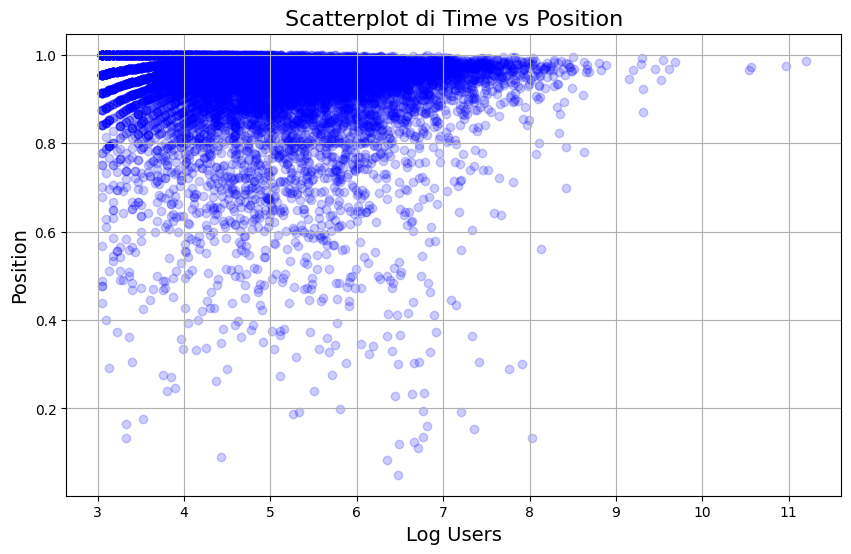

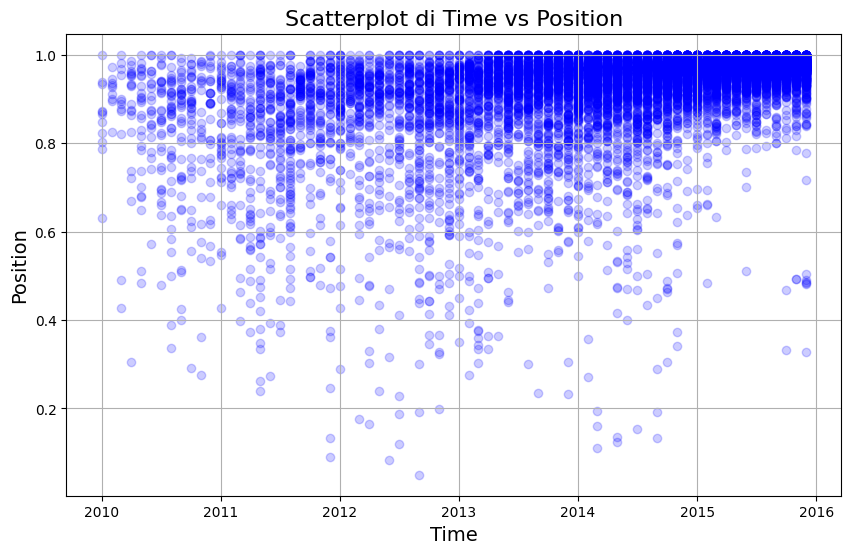

In [266]:
import matplotlib.pyplot as plt

# Supponendo che tu abbia già importato pandas e caricato il tuo DataFrame df
plt.figure(figsize=(10, 6))

plt.scatter(df['log_user_unici'], df['position'], c='blue', alpha=0.2)  # Cambia il colore e la trasparenza se necessario
plt.title('Scatterplot di Time vs Position', fontsize=16)
plt.xlabel('Log Users', fontsize=14)
plt.ylabel('Position', fontsize=14)
plt.grid(True)

plt.show()


import matplotlib.pyplot as plt

# Supponendo che tu abbia già importato pandas e caricato il tuo DataFrame df
plt.figure(figsize=(10, 6))

plt.scatter(df['date'], df['position'], c='blue', alpha=0.2)  # Cambia il colore e la trasparenza se necessario
plt.title('Scatterplot di Time vs Position', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Position', fontsize=14)
plt.grid(True)

plt.show()

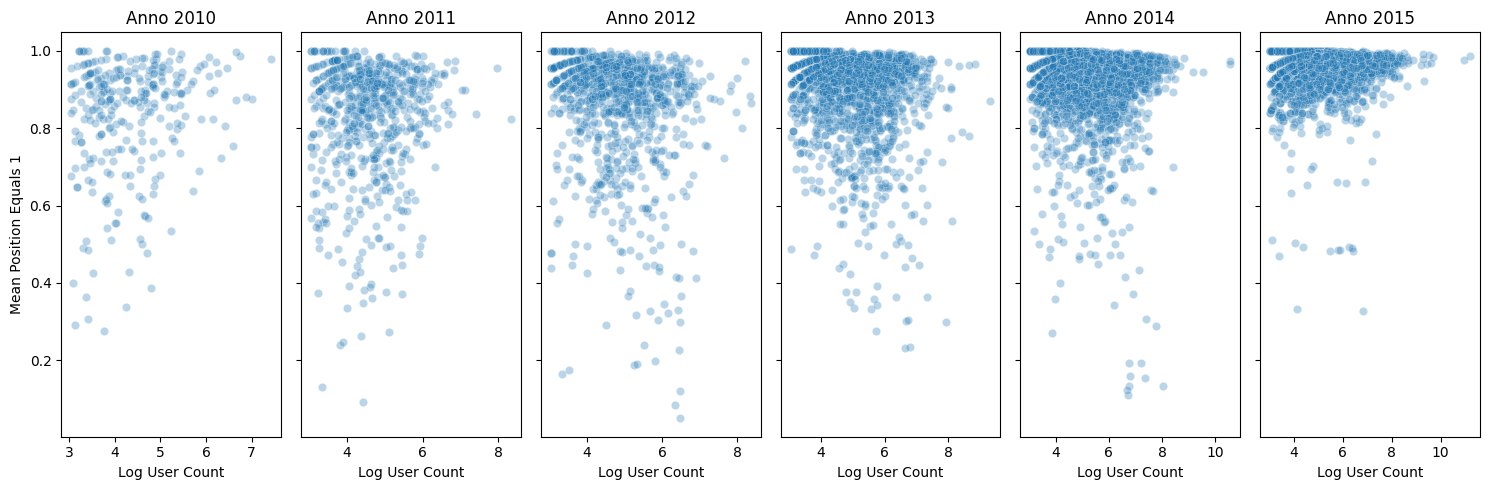

In [267]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'risultato' is your DataFrame and 'user_unici' and 'year' columns exist
risultato['log_user_unici'] = np.log(np.log(risultato['user_unici']))


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'risultato' is your DataFrame and 'user_unici' and 'year' columns exist
risultato['log_user_unici'] = np.log(risultato['user_unici'])
risultato['year']=risultato['date'].dt.year
# Create a sorted list of unique years
years = sorted(risultato['year'].unique())

# Create plots
fig, axes = plt.subplots(1, len(years), figsize=(15, 5), sharey=True)

for i, year in enumerate(years):
    data_year = risultato[risultato['year'] == year]
    sns.scatterplot(x='log_user_unici', y='position', data=data_year, ax=axes[i],alpha=0.3)
    axes[i].set_title(f'Anno {year}')
    axes[i].set_xlabel('Log User Count')
    axes[i].set_ylabel('Mean Position Equals 1')

plt.tight_layout()
plt.show()



/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_

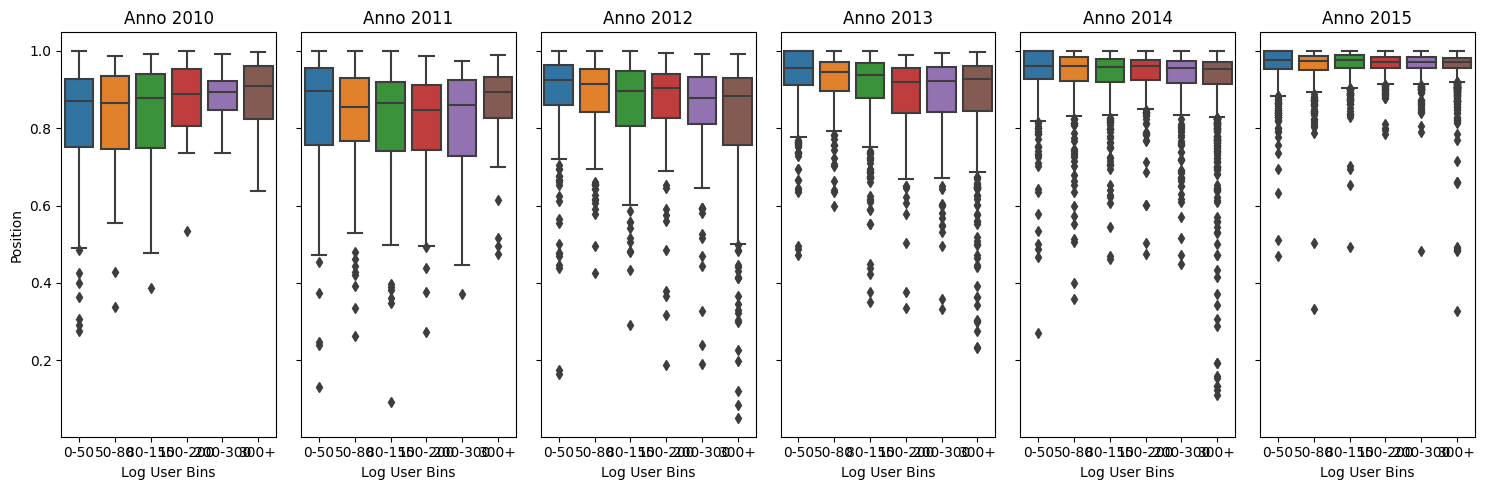

In [268]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'risultato' is your DataFrame and 'user_unici' and 'year' columns exist
risultato['log_user_unici'] = risultato['user_unici']

# Define custom bins
bins = [0, 50, 80, 150,200,300, np.inf]
labels = ['0-50', '50-80', '80-150','150-200','200-300', '300+']

# Create bins for log_user_unici
risultato['log_user_bins'] = pd.cut(risultato['log_user_unici'], bins=bins, labels=labels)

# Create a sorted list of unique years
years = sorted(risultato['year'].unique())

# Create a figure for boxplots
fig, axes = plt.subplots(1, len(years), figsize=(15, 5), sharey=True)

# Loop through each year and plot a boxplot
for i, year in enumerate(years):
    data_year = risultato[risultato['year'] == year]
    
    # Create boxplot for custom bins
    sns.boxplot(x='log_user_bins', y='position', data=data_year, ax=axes[i])
    
    # Set plot title and labels
    axes[i].set_title(f'Anno {year}')
    axes[i].set_xlabel('Log User Bins')
    axes[i].set_ylabel('Position' if i == 0 else '')  # Only show the ylabel on the first plot

# Adjust layout
plt.tight_layout()
plt.show()
